 ## HW4 - EuroSAT Land Use and Land Cover Classification using Deep Learning
 
In this homework, we will build off of the lessons from last homework. Your task is to implement deep learning models to solve a typical problem in satellite imaging  using a benchmark dataset. The homework was designed to make you work on increasingly more complex models. We hope that the homework will be very helpful to improve your skills and knowledge in deep learning!

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.preprocessing import MinMaxScaler
import skimage.io as io

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator

from itertools import product
from tifffile import tifffile 

### S1:

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

- Convert each RGB image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)


In [1]:
# Step 1: Load the data
data_path = "C:/Users/jtrum/pennmusa/MUSA6500/HW4/EuroSAT_RGB"
categories = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]
labels = {category: i for i, category in enumerate(categories)} # create a dictionary of labels
labels

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [3]:
# Step 2: Write a for loop to read in the images and labels
X, y = [], []
for category in categories:
    folder_path = f"{data_path}/{category}"
    for filename in os.listdir(folder_path):
        img_path = f"{folder_path}/{filename}"
        img = io.imread(img_path, as_gray=True) # Reading images as grayscale, thus there will be only one channel
        X.append(img)
        y.append(labels[category])

In [4]:
# Step 3: Convert the data to numpy arrays
X = np.array(X)
y = np.array(y)

In [5]:
# Step 4: Split the data into training (50%) and testing (50%) sets, stratified by the labels
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, stratify=y, random_state=98)

print(f"Training set shape: {X_tr.shape}")
print(f"Testing set shape: {X_te.shape}")
print(f"Training labels shape: {y_tr.shape}")
print(f"Testing labels shape: {y_te.shape}")

Training set shape: (13500, 64, 64)
Testing set shape: (13500, 64, 64)
Training labels shape: (13500,)
Testing labels shape: (13500,)


In [6]:
# Step 5: Reshape the data
X_tr = X_tr.reshape(X_tr.shape[0], -1) # flatten the images to give shape (n, 64*64)
X_te = X_te.reshape(X_te.shape[0], -1) # flatten the images to give shape (n, 64*64)
y_tr_cat = to_categorical(y_tr, num_classes=10) # one-hot encoding of the labels to give shape (n, 10)
y_te_cat = to_categorical(y_te, num_classes=10) # one-hot encoding of the labels to give shape (n, 10)
print("Training data shape:", X_tr.shape)
print("Testing data shape:", X_te.shape)
print("Training labels shape:", y_tr_cat.shape)
print("Testing labels shape:", y_te_cat.shape)


Training data shape: (13500, 4096)
Testing data shape: (13500, 4096)
Training labels shape: (13500, 10)
Testing labels shape: (13500, 10)


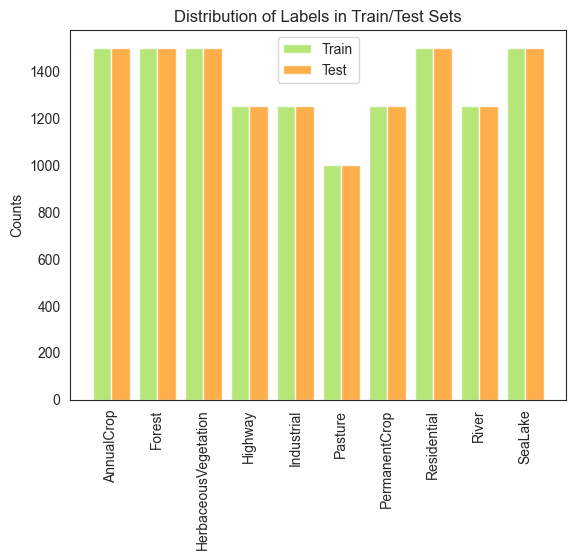

In [42]:
# Step 6: Confirm that the data is balanced
train_counts = np.bincount(y_tr)
test_counts = np.bincount(y_te)

# Plot the distribution of labels in the train and test sets
fig, ax = plt.subplots()
x = np.arange(len(categories))
bar_width = 0.4
opacity = 0.8
tr_color = "#a4df56"
te_color = "#ff9a1f"
ax.bar(x - bar_width/2, train_counts, bar_width, alpha=opacity, label='Train', color=tr_color)
ax.bar(x + bar_width/2, test_counts, bar_width, alpha=opacity, label='Test', color=te_color)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=90)
ax.set_xticklabels(categories)
ax.set_ylabel('Counts')
ax.set_title('Distribution of Labels in Train/Test Sets')
ax.legend()
sns.set_style("white")
plt.show()

### S2:

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

Q2.1: Calculate classification accuracy on the test data.  

In [8]:
# Build a deep learning model with a single fully connected layer
M1 = Sequential()
M1.add(Dense(units=10, # number of classes, acts as the number of neurons in the output layer
             input_dim=X_tr.shape[1], 
             activation='softmax'))
M1.compile(loss='categorical_crossentropy', 
           optimizer='adam', 
           metrics=['accuracy'])
M1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40970     
                                                                 
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Use the history function to plot the training and validation accuracy, and fit the model to get accuracy and loss scores
history = M1.fit(X_tr, y_tr_cat, epochs=15, batch_size=64, validation_data=(X_te, y_te_cat))

Epoch 1/15
211/211 [==============================] - 4s 18ms/step - loss: 2.3474 - accuracy: 0.1293 - val_loss: 2.2817 - val_accuracy: 0.1352
Epoch 2/15
211/211 [==============================] - 2s 8ms/step - loss: 2.2698 - accuracy: 0.1616 - val_loss: 2.2155 - val_accuracy: 0.1550
Epoch 3/15
211/211 [==============================] - 1s 6ms/step - loss: 2.2491 - accuracy: 0.1683 - val_loss: 2.2574 - val_accuracy: 0.1762
Epoch 4/15
211/211 [==============================] - 1s 6ms/step - loss: 2.2292 - accuracy: 0.1907 - val_loss: 2.2439 - val_accuracy: 0.1379
Epoch 5/15
211/211 [==============================] - 1s 5ms/step - loss: 2.1892 - accuracy: 0.1995 - val_loss: 2.2018 - val_accuracy: 0.1708
Epoch 6/15
211/211 [==============================] - 1s 5ms/step - loss: 2.1719 - accuracy: 0.2127 - val_loss: 2.2326 - val_accuracy: 0.1983
Epoch 7/15
211/211 [==============================] - 1s 4ms/step - loss: 2.1739 - accuracy: 0.2162 - val_loss: 2.1586 - val_accuracy: 0.1787
Epoch

In [10]:
# Get the model accuracy score
y_pred_M1 = M1.predict(X_te)
y_pred_M1 = y_pred_M1.argmax(axis=1) # convert one-hot encoded predictions to labels
y_te_pred_M1 = y_te_cat.argmax(axis=1) # convert one-hot encoded test labels to labels
M1_accuracy = accuracy_score(y_te_pred_M1, y_pred_M1)

# Get the training and validation accuracy of each epoch
M1_train_acc = history.history['accuracy']
M1_val_acc = history.history['val_accuracy']
M1_train_loss = history.history['loss']
M1_val_loss = history.history['val_loss']

422/422 [==============================] - 1s 1ms/step


Q2.1: Classification accuracy = 22.7%
The training accuracy steadily increases, and the training loss steadily decreases, but the validation accuracy and loss do not improve after the first few epochs.


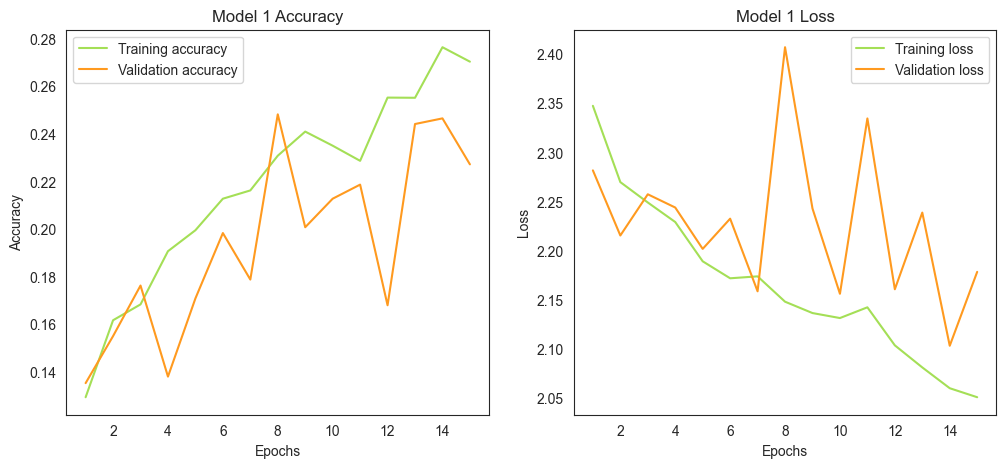

In [11]:
# Print the accuracy score
print("Q2.1: Classification accuracy = %.1f%%" % round(M1_accuracy * 100, 1))
print("The training accuracy steadily increases, and the training loss steadily decreases, but the validation accuracy and loss do not improve after the first few epochs.")

# Create a plot of training vs. validation accuracy
epochs = range(1, len(M1_train_acc) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax1.plot(epochs, M1_train_acc, '-', color=tr_color, label='Training accuracy')
ax1.plot(epochs, M1_val_acc, '-', color=te_color, label='Validation accuracy')
ax1.set_title('Model 1 Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(epochs, M1_train_loss, '-', color=tr_color, label='Training loss')
ax2.plot(epochs, M1_val_loss, '-', color=te_color, label='Validation loss')
ax2.set_title('Model 1 Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()


### S3:

- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

Q3.1: Calculate classification accuracy on the test data.  

In [12]:
num_classes = 10

# Define the model architecture
M2 = Sequential()
M2.add(Dense(units=256, 
             input_dim=X_tr.shape[1], 
             activation='relu')) # Relu activation function for the hidden layer which helps to avoid the vanishing gradient problem (i.e. the gradient of the loss function with respect to the weights is close to zero)
M2.add(Dense(num_classes, activation='softmax')) # Softmax activation function for the output layer which gives the probability of each class

# Compile the model
M2.compile(loss='categorical_crossentropy', 
           optimizer='adam', 
           metrics=['accuracy'])

# Model Summary
M2.summary()

# Train the model
history = M2.fit(X_tr, y_tr_cat, epochs=15, batch_size=64, validation_data=(X_te, y_te_cat))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               1048832   
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 1,051,402
Trainable params: 1,051,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
211/211 [==============================] - 5s 22ms/step - loss: 2.3274 - accuracy: 0.1299 - val_loss: 2.2300 - val_accuracy: 0.1579
Epoch 2/15
211/211 [==============================] - 4s 20ms/step - loss: 2.2096 - accuracy: 0.1533 - val_loss: 2.1917 - val_accuracy: 0.1580
Epoch 3/15
211/211 [==============================] - 4s 21ms/step - loss: 2.1730 - accuracy: 0.1716 - val_loss: 2.1632 - val_accuracy: 0.1882
Epoch 4/15


422/422 [==============================] - 1s 3ms/step
Q3.1: Classification accuracy = 30.7%
Both the training and validation accuracy steadily increase, and both the training and validation steadily decrease, indicating that the model is not 
overfitting.


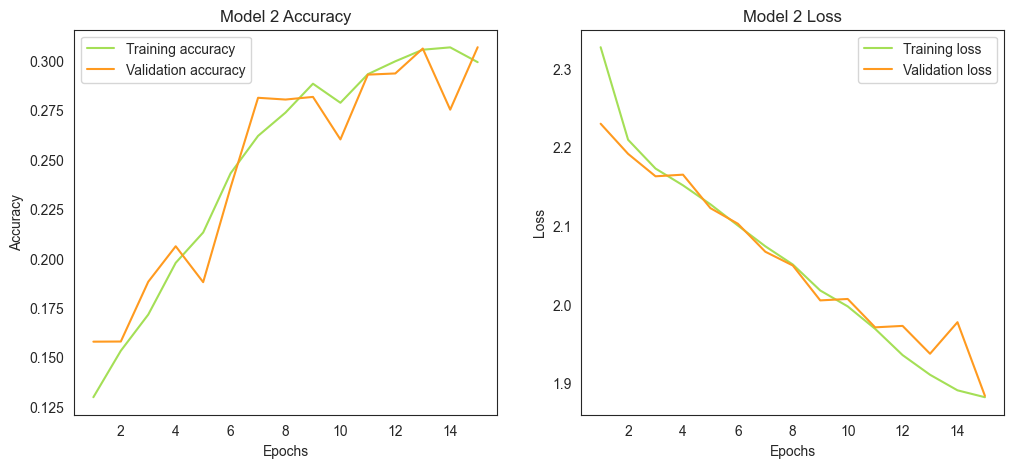

In [13]:
# Get the model accuracy score
y_pred_M2 = M2.predict(X_te)
y_pred_M2 = y_pred_M2.argmax(axis=1)
y_te_pred_M2 = y_te_cat.argmax(axis=1)
M2_accuracy = accuracy_score(y_te_pred_M2, y_pred_M2)

# Get the training and validation accuracy of each epoch
M2_train_acc = history.history['accuracy']
M2_val_acc = history.history['val_accuracy']
M2_train_loss = history.history['loss']
M2_val_loss = history.history['val_loss']

# Print the accuracy score
print("Q3.1: Classification accuracy = %.1f%%" % round(M2_accuracy * 100, 1))
print("Both the training and validation accuracy steadily increase, and both the training and validation steadily decrease, indicating that the model is not \noverfitting.")

# Accuracy plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(epochs, M2_train_acc, '-', color=tr_color, label='Training accuracy')
ax1.plot(epochs, M2_val_acc, '-', color=te_color, label='Validation accuracy')
ax1.set_title('Model 2 Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(epochs, M2_train_loss, '-', color=tr_color, label='Training loss')
ax2.plot(epochs, M2_val_loss, '-', color=te_color, label='Validation loss')
ax2.set_title('Model 2 Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

### S4:

- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model. 

Q4.1: Calculate classification accuracy on the test data.

Q4.2: Compare against previous models. Which model was the "best"? Why?

In [14]:
# define the model
M3 = Sequential()
M3.add(Dense(units=128, input_dim=X_tr.shape[1], activation='relu'))
M3.add(Dropout(0.2)) # Dropout layer to avoid overfitting, 20% as chosen value by trial and error and to avoid complexifying the model
M3.add(Dense(units=256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(units=512, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(units=10, activation='softmax'))

# compile the model
M3.compile(loss='categorical_crossentropy', 
           optimizer='adam', 
           metrics=['accuracy'])

# model summary
M3.summary()

# train the model
history = M3.fit(X_tr, y_tr_cat, epochs=15, batch_size=64, validation_data=(X_te, y_te_cat))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               524416    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 10)               

422/422 [==============================] - 2s 4ms/step
Q4.1: Classification accuracy = 15.9%
The validation accuracy and validation loss experience fluctuations, indicating that the model is overfitting.


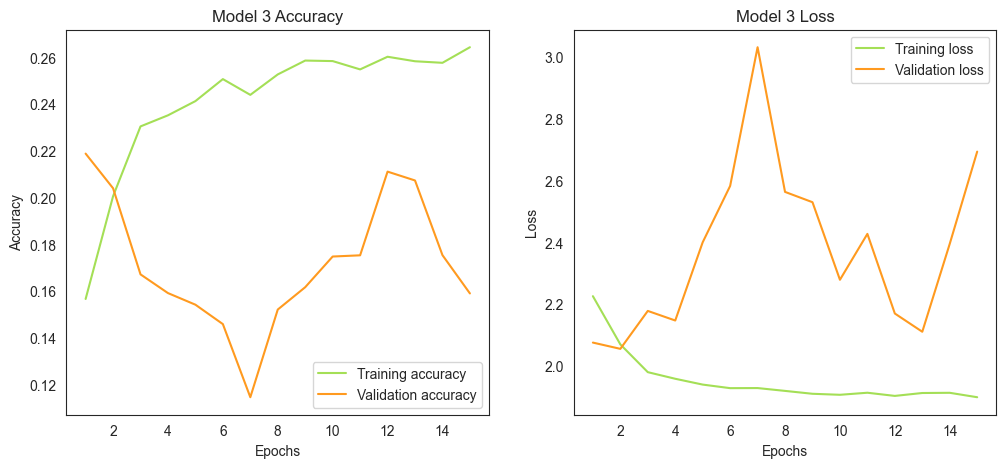

In [15]:
# Get the model accuracy score
y_pred_M3 = M3.predict(X_te)
y_pred_M3 = y_pred_M3.argmax(axis=1)
y_te_pred_M3 = y_te_cat.argmax(axis=1)
M3_accuracy = accuracy_score(y_te_pred_M3, y_pred_M3)

# Get the training and validation accuracy of each epoch
M3_train_acc = history.history['accuracy']
M3_val_acc = history.history['val_accuracy']
M3_train_loss = history.history['loss']
M3_val_loss = history.history['val_loss']

# Print the accuracy score
print("Q4.1: Classification accuracy = %.1f%%" % round(M3_accuracy * 100, 1))
print("The validation accuracy and validation loss experience fluctuations, indicating that the model is overfitting.")

# Accuracy plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(epochs, M3_train_acc, '-', color=tr_color, label='Training accuracy')
ax1.plot(epochs, M3_val_acc, '-', color=te_color, label='Validation accuracy')
ax1.set_title('Model 3 Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(epochs, M3_train_loss, '-', color=tr_color, label='Training loss')
ax2.plot(epochs, M3_val_loss, '-', color=te_color, label='Validation loss')
ax2.set_title('Model 3 Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

Q4.2: Model 2 was the strongest overall fit given it had the highest accuracy score, and also the most steady loss score. While models 1 and 3 experienced increasing training accuracy, they experienced inconsistency across testing model accuracy and both training and validation losses. Model 1 had a weak fit with only one Dense layer. Model 3 was overfit with 3 Dense layers and 3 Dropout layers, and while this can be helpful in identifying variations, it may have been used too frequently and not in a way to regularize the data. While Model 2 is the strongest, its accuracy score is still weak.

### S5:

- Take the original RGB images and do not vectorize them. Use these images as the data input for the following models (M.4 and M.5).
- Implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

Q5.1: Calculate classification accuracy on the test data.

Q5.2: Compare against previous models. Which model was the "best"? Why?

In [16]:
# Re-import the data to preserve RGB channels
img_files = []
for file in glob.glob(data_path + os.sep + "*" + os.sep + "*.jpg"):
  img_files.append(file)

imgs_rgb = []
for imgName in img_files:
  temp = io.imread(imgName)
  imgs_rgb.append(temp) #append to the feature data set

X = np.stack(imgs_rgb) # stack the images into a single array

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=87)

mms = MinMaxScaler()
mms.fit(X_train.reshape(X_train.shape[0], -1))
X_train = mms.transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = mms.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)
y_train_cat = to_categorical(y_train, num_classes=10) # one-hot encoding of the labels to give shape (n, 10)
y_test_cat = to_categorical(y_test, num_classes=10) # one-hot encoding of the labels to give shape (n, 10)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)

X_train shape: (13500, 64, 64, 3)
X_test shape: (13500, 64, 64, 3)
y_train_cat shape: (13500, 10)
y_test_cat shape: (13500, 10)


In [18]:
num_classes = 10
input_shape = (64, 64, 3)

M4 = Sequential()
M4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)) # 32 filters, 3x3 kernel size
M4.add(MaxPooling2D((2, 2))) # 2x2 pooling, which halves the size of the image
M4.add(Dropout(0.25)) # Dropout layer to avoid overfitting, 20% as chosen value by trial and error and to avoid complexifying the model
M4.add(Flatten()) # Flatten the image to a 1D array
M4.add(Dense(num_classes, activation='softmax')) # Output layer, 10 neurons for 10 classes

# Model summary
M4.summary()

# Compile the model
M4.compile(optimizer=RMSprop(), # RMSprop optimizer
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense_7 (Dense)             (None, 10)                307530    
                                                                 
Total params: 308,426
Trainable params: 308,426
Non-trainable params: 0
________________________________________________

In [19]:
# Train model
history_m4 = M4.fit(X_train, y_train_cat, epochs=15, batch_size=64, verbose=1, validation_data=(X_test, y_test_cat))

Epoch 1/15
211/211 [==============================] - 25s 119ms/step - loss: 1.4327 - accuracy: 0.4884 - val_loss: 1.1859 - val_accuracy: 0.5529
Epoch 2/15
211/211 [==============================] - 24s 113ms/step - loss: 1.0146 - accuracy: 0.6373 - val_loss: 1.0246 - val_accuracy: 0.6336
Epoch 3/15
211/211 [==============================] - 24s 115ms/step - loss: 0.9093 - accuracy: 0.6836 - val_loss: 0.8827 - val_accuracy: 0.6864
Epoch 4/15
211/211 [==============================] - 24s 115ms/step - loss: 0.8266 - accuracy: 0.7119 - val_loss: 1.0464 - val_accuracy: 0.6404
Epoch 5/15
211/211 [==============================] - 24s 114ms/step - loss: 0.7731 - accuracy: 0.7323 - val_loss: 1.0320 - val_accuracy: 0.6631
Epoch 6/15
211/211 [==============================] - 24s 113ms/step - loss: 0.7279 - accuracy: 0.7493 - val_loss: 0.8248 - val_accuracy: 0.7013
Epoch 7/15
211/211 [==============================] - 24s 112ms/step - loss: 0.6774 - accuracy: 0.7700 - val_loss: 0.7893 - val_ac

In [20]:
# Get the model accuracy score
y_pred_M4 = M4.predict(X_test)
y_pred_M4 = y_pred_M4.argmax(axis=1)
y_test_pred_M4 = y_test_cat.argmax(axis=1)
M4_accuracy = accuracy_score(y_test_pred_M4, y_pred_M4)

422/422 [==============================] - 8s 18ms/step


Q5.1: Classification accuracy = 70.5%


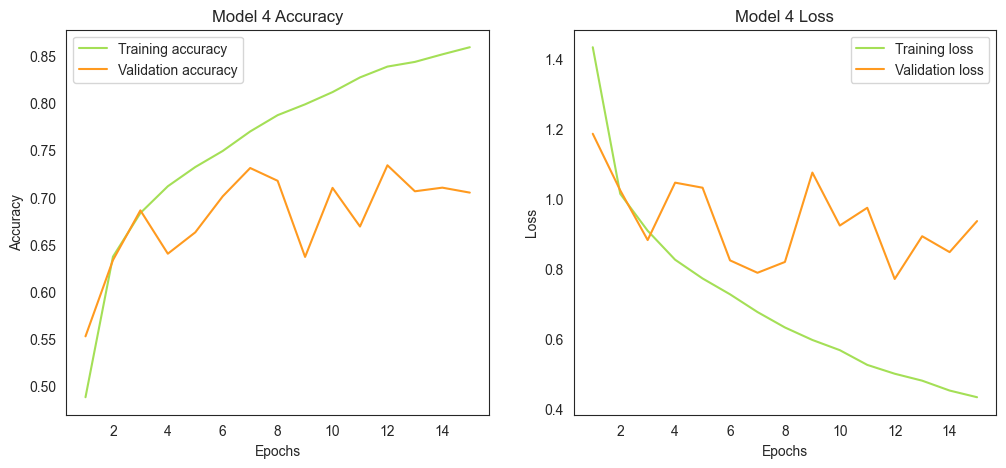

In [21]:
# Print the accuracy score
print("Q5.1: Classification accuracy = %.1f%%" % round(M4_accuracy * 100, 1))

# Get the training and validation accuracy of each epoch
M4_train_acc = history_m4.history['accuracy']
M4_val_acc = history_m4.history['val_accuracy']
M4_train_loss = history_m4.history['loss']
M4_val_loss = history_m4.history['val_loss']

# Accuracy plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(epochs, M4_train_acc, '-', color=tr_color, label='Training accuracy')
ax1.plot(epochs, M4_val_acc, '-', color=te_color, label='Validation accuracy')
ax1.set_title('Model 4 Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(epochs, M4_train_loss, '-', color=tr_color, label='Training loss')
ax2.plot(epochs, M4_val_loss, '-', color=te_color, label='Validation loss')
ax2.set_title('Model 4 Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

Q5.2: Model 4 far outperforms Models 1 through 3 with decreasing loss scores under 1 and the highest accuracy score. The validation accuracy and loss scores steadily improved until leveling out, but show more consistency than the other models, especially 1 and 3. Not vectorizing the data allowed for layers such as 2D convolution and max pooling, which helps with granularizing the data and adding spatial comparison effects, which inevitably will make the model improve in predictive power.

### S6:

- Using RGB images from S5, implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer learning. 

Q6.1: Describe the model you built, and why you chose it.

Q6.2: Calculate classification accuracy on the test data.

Q6.3: Compare against previous models. Which model was the "best"? Why?

Q6.4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.

6.1: The model I created is an 18 layered convolutional neural network that utilizes techniques seen in previous models, but uses them more frequently. There are several more convolutional 2D layers and fully connected layers, helping the model learn more spatial characteristics of the features and images. More batch normalization helps standardize the outputs. Increasing dropouts likely helps mitigating any overfitting that adding so many layers could cause. Some new features include data augmentation - using shifting, zooming, and flipping helps with the model's generalizability and recognize even more spatial characteristics of the features. The Adam optimizer was also assigned a rate of 0.001, which through research seems to help with stability and optimization in deep learning models.

I chose this model because I believe it will provide much more spatial information, and the potential negative impacts of model overfitting are engineered into the model, thus it should learn significantly more information without worrying about diminishing accuracy.

In [22]:
num_classes = 10
input_shape = (64, 64, 3)

M5 = Sequential()
M5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
M5.add(BatchNormalization()) # Batch normalization layer helps normalize input layer by re-centering and re-scaling
M5.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
M5.add(MaxPooling2D((2, 2)))
M5.add(Dropout(0.25))
M5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
M5.add(BatchNormalization())
M5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
M5.add(MaxPooling2D((2, 2)))
M5.add(Dropout(0.25))
M5.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
M5.add(BatchNormalization())
M5.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
M5.add(MaxPooling2D((2, 2)))
M5.add(Dropout(0.25))
M5.add(Flatten()) # Flatten the image to a 1D array
M5.add(Dense(256, activation='relu'))
M5.add(Dropout(0.5))
M5.add(Dense(num_classes, activation='softmax'))

M5.summary()

# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, # randomly rotate images in the range (degrees, 0 to 180)
                             width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                             zoom_range=0.2, # Randomly zoom image
                             horizontal_flip=True,
                             vertical_flip=False)

# Compile the model
M5.compile(optimizer=Adam(learning_rate=0.001), # learning rate helps to control the step size at each iteration while moving toward a minimum of a loss function
           loss='categorical_crossentropy',
           metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 12

history = M5.fit(datagen.flow(X_train, y_train_cat, batch_size=batch_size), # datagen.flow() generates batches of augmented data
                 steps_per_epoch=len(X_train) / batch_size, # steps_per_epoch is the number of batches to draw from the generator at each epoch
                 epochs=epochs,
                 validation_data=(X_test, y_test_cat))

# Evaluate the model
test_loss, test_acc = M5.evaluate(X_test, y_test_cat)
print('Test accuracy:', test_acc)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)       

In [23]:
# Get the model accuracy score
y_pred_M5 = M5.predict(X_test)
y_pred_M5 = y_pred_M5.argmax(axis=1)
y_test_pred_M5 = y_test_cat.argmax(axis=1)
M5_accuracy = accuracy_score(y_test_pred_M5, y_pred_M5)

422/422 [==============================] - 27s 64ms/step


Q6.2: Classification accuracy = 78.4%


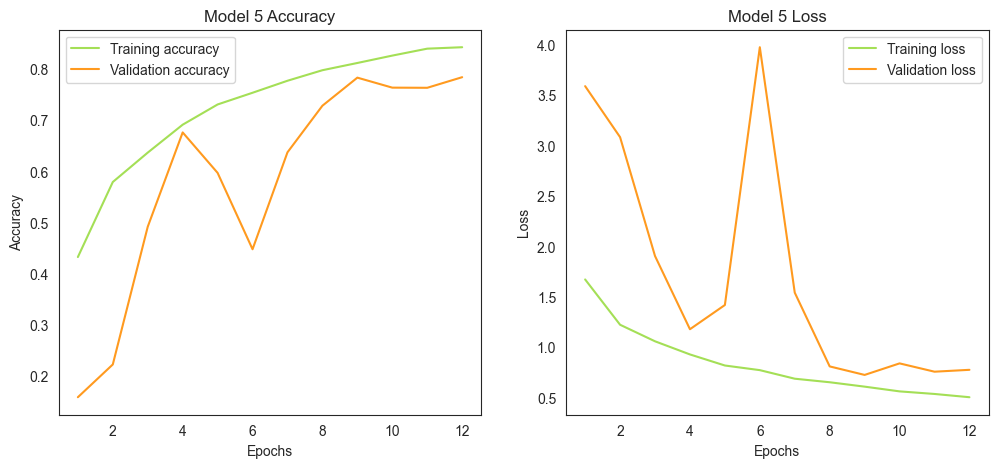

In [25]:
# Print the accuracy score
print("Q6.2: Classification accuracy = %.1f%%" % round(M5_accuracy * 100, 1))

# Get the training and validation accuracy of each epoch
M5_train_acc = history.history['accuracy']
M5_val_acc = history.history['val_accuracy']
M5_train_loss = history.history['loss']
M5_val_loss = history.history['val_loss']

epochs = range(1, len(M5_train_acc) + 1)

# Accuracy plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(epochs, M5_train_acc, '-', color=tr_color, label='Training accuracy')
ax1.plot(epochs, M5_val_acc, '-', color=te_color, label='Validation accuracy')
ax1.set_title('Model 5 Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(epochs, M5_train_loss, '-', color=tr_color, label='Training loss')
ax2.plot(epochs, M5_val_loss, '-', color=te_color, label='Validation loss')
ax2.set_title('Model 5 Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

6.3: Using the accuracy metric, model 5 outperforms all previous models. However, it did have a much higher loss score than model 4. The validation loss and accuracy have stark changes around epoch 6. indicating the model may be overfitting, but the trend smoothed out eventually thus I would still argue Model 5 is the best.

In [26]:
categories

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [43]:
labels

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

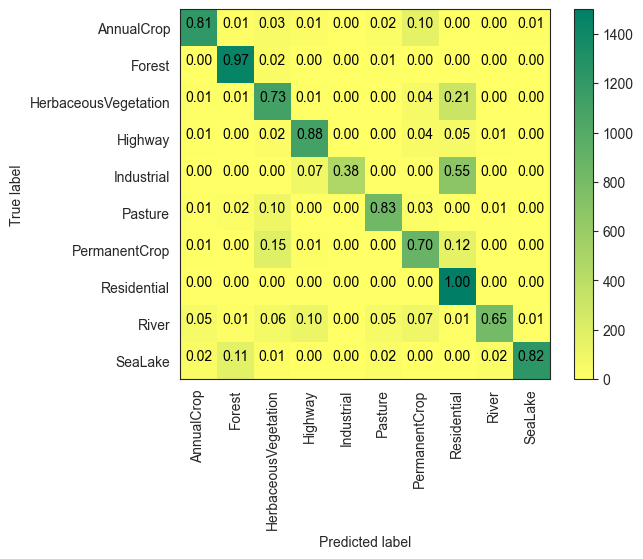

In [46]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_pred_M5, y_pred_M5)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.summer_r)
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=90)
plt.yticks(tick_marks, categories)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add text in each cell indicating the percentage of samples with that combination of true and predicted labels
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize the confusion matrix by row
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:.2f}".format(cm_norm[i, j]),
             horizontalalignment="center",
             color="black")
    
plt.show()

6.4: We see that Industrial (or 4) and River (or 8) have the two lowest accuracies with 38% and 65% accuracy, respectively.

Predicted label:  Residential
True label:  Industrial


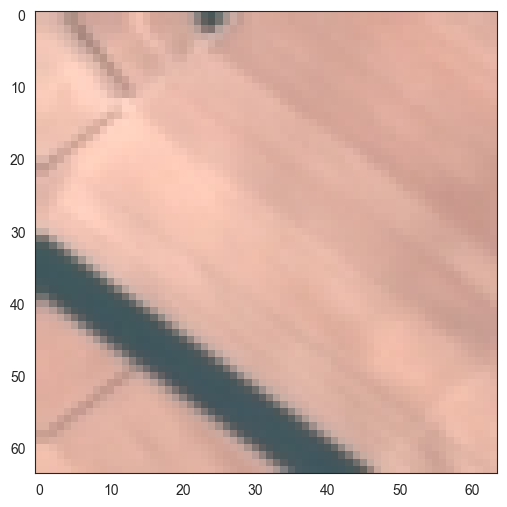

In [102]:
plt.figure(figsize=(6,6))
a = np.where((y_test_pred_M5==4) & (y_pred_M5 == 7))[0][131]
aImg = io.imread(img_files[a])
plt.imshow(aImg)
print("Predicted label: ", categories[y_pred_M5[a]])
print("True label: ", categories[y_test_pred_M5[a]])

Predicted label:  Forest
True label:  River


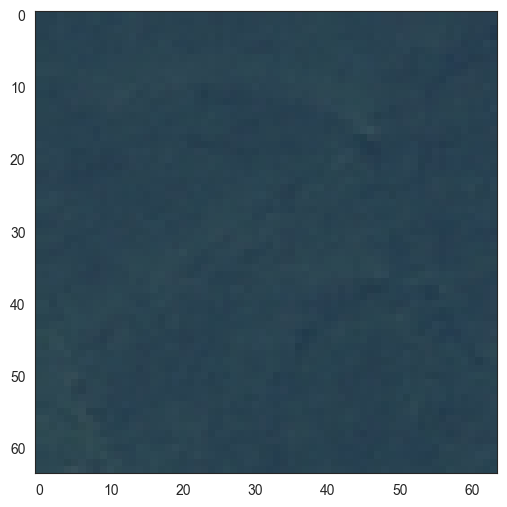

In [75]:
plt.figure(figsize=(6,6))
b = np.where((y_test_pred_M5 == 8) & (y_pred_M5 == 1))[0][5]
bImg = io.imread(img_files[b])
plt.imshow(bImg)
print("Predicted label: ", categories[y_pred_M5[b]])
print("True label: ", categories[y_test_pred_M5[b]])

Not sure if either of these make sense given the categories, but with the data augmentation including the zoom function, these may just be zoomed in on the wrong part of the image to highlight the true land class.

### S7:

- Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).

Q7.1: Calculate classification accuracy on the test data.

Q7.2: Compare against results using RGB images.

In [31]:
import fileinput
import io
import pathlib
import requests
import zipfile
from pathlib import Path

response = requests.get("https://huggingface.co/datasets/torchgeo/eurosat/resolve/main/EuroSATallBands.zip")

O_dir = pathlib.Path("euro_sat")
O_dir.mkdir(exist_ok=True)

with io.BytesIO(response.content) as f: # download the file
     with zipfile.ZipFile(f) as zf:
         zf.extractall(O_dir)

for dataset in O_dir.glob("*.zip"): # unzip the downloaded file
    with open(dataset,"rb") as f:
         with zipfile.ZipFile(f) as zf:
             zf.extractall(O_dir / dataset.stem)

for dataset in O_dir.rglob("*.zip"): # delete the zip file
     dataset.unlink()

import os
import skimage
from skimage import io

raw_ms_labels = []
raw_ms_images = []
here = Path(os.getcwd())
for idx, directory in enumerate((here / "euro_sat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif").glob("*")): #
    for img_path in directory.glob("*.tif"):
        raw_ms_labels.append(idx)
        raw_ms_images.append(io.imread(img_path))
# convert to numpy arrays
X = np.array(raw_ms_images)
y = np.array(raw_ms_labels)

Vegetation related analyses, such as enhanced vegetation index, utilize blue, red and near-infrared bands. These are the ones I will be using given the amount of classifications related to croplands and vegetation. For EuroSAT, these bands are 2, 4 and 8.

In [32]:
veg = X[:,:,:,[2, 4, 8]] # selecting channels 2, 4 and 8
veg.shape

(27000, 64, 64, 3)

In [33]:
X_tr_V, X_te_V, y_tr_V, y_te_V = train_test_split(veg,
                                                  y,
                                                  test_size=0.5, 
                                                  random_state=76, 
                                                  stratify=y)

mms = MinMaxScaler()
mms.fit(X_tr_V.reshape(X_tr_V.shape[0], -1))
X_tr_V = mms.transform(X_tr_V.reshape(X_tr_V.shape[0], -1)).reshape(X_tr_V.shape)
X_te_V = mms.transform(X_te_V.reshape(X_te_V.shape[0], -1)).reshape(X_te_V.shape)
y_tr_V = to_categorical(y_tr_V, num_classes=10) # one-hot encoding of the labels to give shape (n, 10)
y_te_V = to_categorical(y_te_V, num_classes=10) # one-hot encoding of the labels to give shape (n, 10)
print("Vegetation training shape:", X_tr_V.shape)
print("Vegetation testing shape:", X_te_V.shape)
print("Vegetation training labels shape:", y_tr_V.shape)
print("Vegetation testing labels shape:", y_te_V.shape)

Vegetation training shape: (13500, 64, 64, 3)
Vegetation testing shape: (13500, 64, 64, 3)
Vegetation training labels shape: (13500, 10)
Vegetation testing labels shape: (13500, 10)


In [35]:
M5.fit(X_tr_V, y_tr_V,
       batch_size=batch_size,
       epochs=12,
       validation_data=(X_te_V, y_te_V))

Epoch 1/12
211/211 [==============================] - 155s 735ms/step - loss: 1.0978 - accuracy: 0.6089 - val_loss: 0.9430 - val_accuracy: 0.6421
Epoch 2/12
211/211 [==============================] - 319s 2s/step - loss: 0.8440 - accuracy: 0.7030 - val_loss: 1.4242 - val_accuracy: 0.5805
Epoch 3/12
211/211 [==============================] - 208s 984ms/step - loss: 0.7473 - accuracy: 0.7345 - val_loss: 1.3773 - val_accuracy: 0.5549
Epoch 4/12
211/211 [==============================] - 168s 795ms/step - loss: 0.6868 - accuracy: 0.7620 - val_loss: 0.9728 - val_accuracy: 0.6699
Epoch 5/12
211/211 [==============================] - 186s 884ms/step - loss: 0.6232 - accuracy: 0.7799 - val_loss: 0.8516 - val_accuracy: 0.7033
Epoch 6/12
211/211 [==============================] - 164s 779ms/step - loss: 0.5907 - accuracy: 0.7941 - val_loss: 0.6782 - val_accuracy: 0.7796
Epoch 7/12
211/211 [==============================] - 156s 738ms/step - loss: 0.5453 - accuracy: 0.8088 - val_loss: 0.6867 - va

422/422 [==============================] - 25s 59ms/step
Q7.1: Classification accuracy = 59.1%


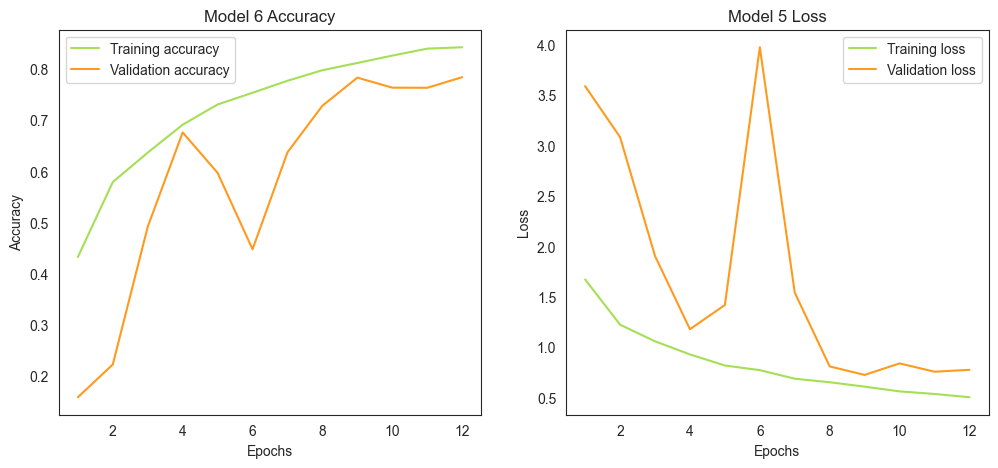

In [40]:
# Get the model accuracy score
y_pred_V = M5.predict(X_te_V)
y_pred_V = y_pred_V.argmax(axis=1)
y_true_V = y_te_V.argmax(axis=1)
V_accuracy = accuracy_score(y_true_V, y_pred_V)

# Print the accuracy score
print("Q7.1: Classification accuracy = %.1f%%" % round(V_accuracy * 100, 1))

# Get the training and validation accuracy of each epoch
V_train_acc = history.history['accuracy']
V_val_acc = history.history['val_accuracy']
V_train_loss = history.history['loss']
V_val_loss = history.history['val_loss']

epochs = range(1, len(V_train_acc) + 1)

# Accuracy plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(epochs, V_train_acc, '-', color=tr_color, label='Training accuracy')
ax1.plot(epochs, V_val_acc, '-', color=te_color, label='Validation accuracy')
ax1.set_title('Model 6 Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(epochs, V_train_loss, '-', color=tr_color, label='Training loss')
ax2.plot(epochs, V_val_loss, '-', color=te_color, label='Validation loss')
ax2.set_title('Model 5 Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

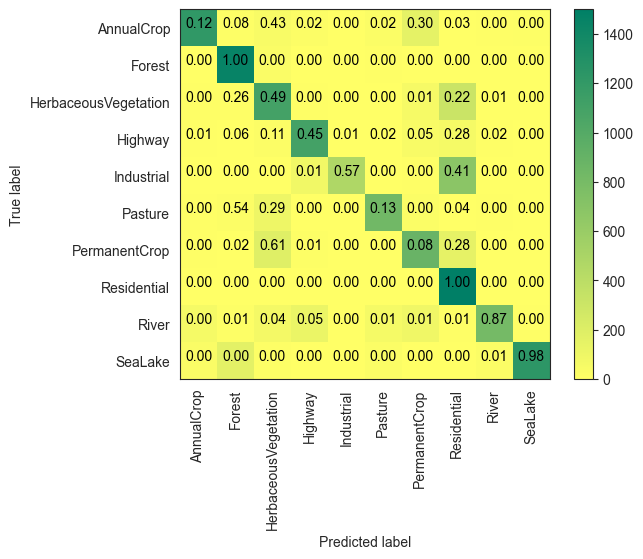

In [41]:
# Calculate the confusion matrix
cmV = confusion_matrix(y_true_V, y_pred_V)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.summer_r)
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=90)
plt.yticks(tick_marks, categories)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add text in each cell indicating the percentage of samples with that combination of true and predicted labels
cm_normV = cmV.astype('float') / cmV.sum(axis=1)[:, np.newaxis] # Normalize the confusion matrix by row
for i, j in product(range(cmV.shape[0]), range(cmV.shape[1])):
    plt.text(j, i, "{:.2f}".format(cm_normV[i, j]),
             horizontalalignment="center",
             color="black")
    
plt.show()

7.2: The results of applying the vegetation-based model were somewhat surprising. While there were mild improvements in certain scores, some classes experienced a significant drop in classification accuracy. Specifically, the annual crop, pasture, and permanent crop classes were most affected. It is possible that a model utilizing only the red and NIR bands could provide better results for these classes. On the other hand, some unexpected improvements were observed in the industrial and residential classes, while the forest class saw a perfect 100% accuracy, which aligns with the selected band combination.

Overall, the RGB model outperformed the vegetation-based model, likely due to its greater generalizability across multiple land classes. While the vegetation band index benefited certain classes, it resulted in extremely low accuracy for others. In contrast, the RGB model produced accuracies ranging from 60 to 90% for most classes, resulting in higher overall accuracy and lower loss. The RGB model showed more consistent accuracy across all classes due to the inherent consistency of this band combination.